In [59]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import pandas as pd
import glob
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

## KenPom data

In [4]:
# this cell loads each season's .csv file to respective 'kenpom' variable name
years = np.arange(14, 20)

kp_list = []
for x in years:
    x = "kenpom" + str(x)
    kp_list.append(x)
    
var_list = tuple(zip(kp_list, years))

for var in var_list:
    globals()[var[0]] = pd.read_csv("summary" + str(var[1]) + "_pt.csv")

In [5]:
import sqlalchemy

# connect to database system
# pd.read_sql takes in a parameter for a SQLite engine, which we create below
sqlite_uri = "sqlite:///marchmadness.db"
sqlite_engine = sqlalchemy.create_engine(sqlite_uri)

In [6]:
# start with an empty database - DROP the tables if they
# already exist in the database (from a previous run)
sql_expr = """
DROP TABLE IF EXISTS kenpom14;
"""
result = sqlite_engine.execute(sql_expr)

sql_expr = """
DROP TABLE IF EXISTS kenpom15;
"""
result = sqlite_engine.execute(sql_expr)

sql_expr = """
DROP TABLE IF EXISTS kenpom16;
"""
result = sqlite_engine.execute(sql_expr)

sql_expr = """
DROP TABLE IF EXISTS kenpom17;
"""
result = sqlite_engine.execute(sql_expr)

sql_expr = """
DROP TABLE IF EXISTS kenpom18;
"""
result = sqlite_engine.execute(sql_expr)

sql_expr = """
DROP TABLE IF EXISTS kenpom19;
"""
result = sqlite_engine.execute(sql_expr)

sql_expr = """
DROP TABLE IF EXISTS kenpom_all;
"""
result = sqlite_engine.execute(sql_expr)

In [7]:
# populate kenpom SQL tables
for var in var_list:
    globals()[var[0]] = globals()[var[0]].to_sql("kenpom" + str(var[1]), con = sqlite_engine)

In [8]:
# concatenate all kenpom seasons into same table
# create 'Relative AdjEM' variable that quantifies team's strength relative to best team in country
sql_expr = """
SELECT
    *,
    AdjEM / (SELECT MAX(AdjEM) from kenpom14) AS RelativeAdjEM
FROM kenpom14

UNION

SELECT
    *,
    AdjEM / (SELECT MAX(AdjEM) from kenpom15) AS RelativeAdjEM
FROM kenpom15

UNION

SELECT
    *,
    AdjEM / (SELECT MAX(AdjEM) from kenpom16) AS RelativeAdjEM
FROM kenpom16

UNION

SELECT
    *,
    AdjEM / (SELECT MAX(AdjEM) from kenpom17) AS RelativeAdjEM
FROM kenpom17

UNION

SELECT
    *,
    AdjEM / (SELECT MAX(AdjEM) from kenpom18) AS RelativeAdjEM
FROM kenpom18

UNION

SELECT
    *,
    AdjEM / (SELECT MAX(AdjEM) from kenpom19) AS RelativeAdjEM
FROM kenpom19
"""

kenpom_all = pd.read_sql(sql_expr, sqlite_engine)
kenpom_all = kenpom_all.to_sql('kenpom_all', con = sqlite_engine)

In [9]:
# drop irrelevant columns
sql_expr = """
SELECT
    Season,
    TeamName AS Team,
    seed,
    AdjEM,
    RankAdjEM,
    RelativeAdjEM,
    AdjTempo,
    RankAdjTempo,
    AdjOE,
    RankAdjOE,
    AdjDE,
    RankAdjDE
FROM kenpom_all
WHERE NOT seed = 'NaN'
ORDER BY
    Season,
    seed,
    AdjEM DESC
"""

kenpom = pd.read_sql(sql_expr, sqlite_engine)

In [10]:
kenpom['Team'] = kenpom['Team'].astype('string')
kenpom

,Season,Team,seed,AdjEM,RankAdjEM,RelativeAdjEM,AdjTempo,RankAdjTempo,AdjOE,RankAdjOE,AdjDE,RankAdjDE
0,2014,Arizona,1.0,30.39640,2,0.994396,63.1175,267,115.1930,24,84.7964,1
1,2014,Florida,1.0,27.81060,3,0.909803,61.5519,317,116.2160,18,88.4056,4
2,2014,Virginia,1.0,26.42850,4,0.864589,59.6528,345,113.8500,31,87.4218,2
3,2014,Wichita St.,1.0,25.18040,8,0.823758,63.5718,245,117.1170,15,91.9370,11
4,2014,Kansas,2.0,25.40110,5,0.830978,66.8907,78,119.9740,6,94.5731,27
...,...,...,...,...,...,...,...,...,...,...,...,...
403,2019,Iona,16.0,-3.07828,197,-0.086335,70.5217,45,106.5140,132,109.5930,275
404,2019,North Dakota St.,16.0,-3.19855,199,-0.089708,64.7859,312,106.5520,127,109.7510,278
405,2019,Fairleigh Dickinson,16.0,-4.24870,208,-0.119161,66.7742,214,106.1840,137,110.4320,295
406,2019,Prairie View A&M,16.0,-4.30871,209,-0.120844,70.9610,34,101.5300,226,105.8380,205


## FiveThirtyEight Data

In [11]:
five38_file_extension = 'FiveThirtyEight.csv'
five38_filenames = [i for i in glob.glob(f"*{five38_file_extension}")]

In [12]:
combined_538_data = pd.DataFrame()
for file in five38_filenames:
    tourney = pd.read_csv(file)
    tourney.insert(0, 'Season', pd.to_numeric(file[0:4]))
    combined_538_data = pd.concat([combined_538_data, tourney])

In [13]:
fivethirtyeight = combined_538_data.drop(columns = ['team_alive', 'team_region', 'playin_flag', 
                                                    'rd1_win', 'timestamp', 'win_odds', 'team_id',
                                                    'gender', 'forecast_date', 'results_to', 'team_slot']) \
                                   .rename(columns = {'team_name': 'Team',
                                                      'team_seed': 'Seed',
                                                      'rd2_win': 'P(R32)',
                                                      'rd3_win': 'P(S16)', 
                                                      'rd4_win': 'P(E8)', 
                                                      'rd5_win': 'P(F4)', 
                                                      'rd6_win': 'P(Finals)', 
                                                      'rd7_win': 'P(Champion)'})

fivethirtyeight['Seed'] = fivethirtyeight['Seed'].astype('string')
fivethirtyeight['Seed'] = pd.to_numeric(fivethirtyeight['Seed'].str.replace('[a-z]+', ''))
fivethirtyeight['Team'] = fivethirtyeight['Team'].astype('string')
fivethirtyeight

,Season,Team,finish,Seed,P(R32),P(S16),P(E8),P(F4),P(Finals),P(Champion),team_rating
0,2014,Albany,1,16,0.012296,0.002051,0.000283,0.000032,0.000004,3.948740e-07,NaN
1,2014,American,1,15,0.071595,0.020689,0.003560,0.000373,0.000047,7.626705e-06,NaN
2,2014,Arizona,4,1,0.977695,0.726877,0.582110,0.423917,0.230737,1.335146e-01,NaN
3,2014,Arizona St.,1,10,0.498813,0.124986,0.031258,0.005652,0.001842,6.024659e-04,NaN
4,2014,Baylor,3,6,0.703237,0.338103,0.143483,0.044268,0.017873,8.000559e-03,NaN
...,...,...,...,...,...,...,...,...,...,...,...
59,2019,Virginia Tech,3,4,0.888466,0.617061,0.187704,0.102977,0.044954,1.977161e-02,89.26
60,2019,Washington,2,9,0.494005,0.065142,0.020543,0.006295,0.001581,4.003935e-04,82.55
61,2019,Wisconsin,1,5,0.600614,0.330329,0.088254,0.037996,0.018056,7.172178e-03,86.54
62,2019,Wofford,2,7,0.633499,0.185530,0.078656,0.025003,0.007437,2.204709e-03,84.38


In [323]:
# merge kenpom and fivethirtyeight data
teams = kenpom.merge(fivethirtyeight, on = ['Season', 'Team'])
teams = teams.drop(columns = ['seed'])
teams

,Season,Team,AdjEM,RankAdjEM,RelativeAdjEM,AdjTempo,RankAdjTempo,AdjOE,RankAdjOE,AdjDE,RankAdjDE,finish,Seed,P(R32),P(S16),P(E8),P(F4),P(Finals),P(Champion),team_rating
0,2014,Arizona,30.396400,2,0.994396,63.1175,267,115.193,24,84.7964,1,4,1,0.977695,0.726877,0.582110,0.423917,2.307372e-01,1.335146e-01,NaN
1,2014,Florida,27.810600,3,0.909803,61.5519,317,116.216,18,88.4056,4,5,1,0.987704,0.839049,0.624133,0.410778,2.608404e-01,1.445541e-01,NaN
2,2014,Virginia,26.428500,4,0.864589,59.6528,345,113.850,31,87.4218,2,3,1,0.963892,0.707825,0.389376,0.232919,1.208479e-01,6.018022e-02,NaN
3,2014,Wichita St.,25.180400,8,0.823758,63.5718,245,117.117,15,91.9370,11,2,1,0.975454,0.591415,0.243995,0.135568,7.911604e-02,4.512231e-02,NaN
4,2014,Kansas,25.401100,5,0.830978,66.8907,78,119.974,6,94.5731,27,2,2,0.924029,0.670385,0.418317,0.208164,1.223133e-01,6.216315e-02,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,2019,Bradley,-0.358275,165,-0.010048,65.0632,299,100.892,246,101.2500,117,1,15,0.035534,0.005590,0.000838,0.000050,5.557695e-06,6.963860e-07,72.91
380,2019,Gardner Webb,-0.743522,167,-0.020853,67.0883,196,107.475,111,108.2180,253,1,16,0.018566,0.003724,0.000541,0.000047,4.268423e-06,3.358270e-07,71.74
381,2019,Iona,-3.078280,197,-0.086335,70.5217,45,106.514,132,109.5930,275,1,16,0.022087,0.004434,0.000387,0.000034,2.586424e-06,2.084330e-07,71.88
382,2019,North Dakota St.,-3.198550,199,-0.089708,64.7859,312,106.552,127,109.7510,278,1,16,0.008211,0.001026,0.000081,0.000006,5.366850e-07,5.417200e-08,70.79


In [324]:
# assign std. dev. and mean values to features 
# for re-orienting units later

AdjOE_std = np.std(teams.AdjOE)
AdjOE_mean = np.mean(teams.AdjOE)

AdjDE_std = np.std(teams.AdjDE)
AdjDE_mean = np.mean(teams.AdjDE)

## Construct k-NN Algorithm for Classifying March Madness Round of 64 Outcome

### 2 Features: AdjOE, AdjDE
### Classifying W/L outcome in R64

In [292]:
def standard_units(x):
    "Convert any array of numbers to standard units."
    return (x - np.average(x)) / np.std(x, ddof = 1)

In [140]:
%%time
# computationally expensive (35 minute run time)

teams = kenpom.merge(fivethirtyeight, on = ['Season', 'Team'])
teams = teams.drop(columns = ['seed'])

# convert features to standard units so they
# hold equal weight in distance to neighbors
teams = teams[['AdjOE', 'AdjDE', 'finish']]
teams = pd.DataFrame(
         {"AdjOE": standard_units(teams.AdjOE),
          "AdjDE": standard_units(teams.AdjDE),
          "finish": teams.finish})

# make binary variable to denote if team advanced to 2nd Round (R32) or not
finishes = []
for finish in teams.finish:
    if finish > 1:
        finish = 2
        finishes.append(finish)
    else:
        finishes.append(finish)
teams.finish = finishes

# number of rows in df
num_rows = teams.shape[0]

# number of rows put into testing data
# 20% of entire dataset
per_fold = (num_rows // 5) + 1


optimal_k_list = []
accuracy_list = []
num_reps = 5
# run num_reps simulations of shuffling test/train data
# to tune k-parameter and return accuracy on test data
for n in np.arange(1, num_reps + 1):
    print('...REP ' + str(n) + '...')

    # shuffle rows of teams df
    teams = teams.sample(frac = 1)

    # create testing data
    testing_fold = teams[-per_fold:]

    # remove testing data from df
    # 80% of entire dataset
    training_fold = teams[:-per_fold]

    # initialize score_dict to be all zeros
    score_dict = {}
    for k in np.arange(11, 40, 2):
        score_dict[k] = 0

    # run n simulations of k-parameter tuning
    # shuffles cv folds in training data and 
    # computes cv score n times
    n = 100
    for n in np.arange(1, n+1):

        # shuffle rows in training data
        training_fold = training_fold.sample(frac = 1)

        # separate predictors from outcome variable
        training_X = np.asarray(training_fold.drop(columns = ['finish']))
        training_Y = np.asarray(training_fold['finish'])

        # tune k parameter (only odd numbers to break ties)
        # k below 11 not smooth enough
        for k in np.arange(11, 40, 2):
            knn = KNeighborsClassifier(n_neighbors = k, algorithm = 'brute')
            # 10-fold cross validation
            score = round(np.mean(cross_val_score(knn, training_X, training_Y, cv = 10)), 4)
            score_dict[k] += score


    # return average cv score for each k parameter
    for k, v in score_dict.items():
        v = round(v / n, 4)
        score_dict[k] = v
    print('Score Dictionary:')
    print(score_dict)

    optimal_k = max(score_dict, key = score_dict.get)
    optimal_k_list.append(optimal_k)
    print('Optimal k:', optimal_k)
    print('Cross-Validation Score:', round(score_dict.get(optimal_k), 3))

    # separate predictors from outcome variable in testing fold
    testing_fold_x = np.asarray(testing_fold.drop(columns = ['finish']))
    testing_fold_y = np.asarray(testing_fold['finish'])

    # return score of k-NN algorithm on testing fold with optimal k parameter
    knn = KNeighborsClassifier(n_neighbors = optimal_k, algorithm = 'brute')
    fit = knn.fit(training_X, training_Y)
    accuracy = fit.score(testing_fold_x, testing_fold_y)
    accuracy_list.append(accuracy)
    print('Testing Accuracy:', round(accuracy, 4))
    print('\n')

from collections import Counter
print(Counter(optimal_k_list).most_common())
print('Mean Testing Accuracy:', round(np.mean(accuracy_list), 4))
print('\n')

...REP 1...
Score Dictionary:
{11: 0.7481, 13: 0.7516, 15: 0.7499, 17: 0.7468, 19: 0.742, 21: 0.7364, 23: 0.7338, 25: 0.7352, 27: 0.7375, 29: 0.7403, 31: 0.7464, 33: 0.7517, 35: 0.7519, 37: 0.7495, 39: 0.7474}
Optimal k: 35
Cross-Validation Score: 0.752
Testing Accuracy: 0.6623


...REP 2...
Score Dictionary:
{11: 0.7108, 13: 0.7189, 15: 0.7209, 17: 0.7207, 19: 0.7251, 21: 0.7277, 23: 0.7293, 25: 0.7322, 27: 0.7319, 29: 0.7282, 31: 0.7234, 33: 0.7238, 35: 0.7229, 37: 0.7177, 39: 0.7161}
Optimal k: 25
Cross-Validation Score: 0.732
Testing Accuracy: 0.7013


...REP 3...
Score Dictionary:
{11: 0.7186, 13: 0.7218, 15: 0.7219, 17: 0.7143, 19: 0.7079, 21: 0.7126, 23: 0.7189, 25: 0.7207, 27: 0.7258, 29: 0.7321, 31: 0.7343, 33: 0.7367, 35: 0.7383, 37: 0.74, 39: 0.7406}
Optimal k: 39
Cross-Validation Score: 0.741
Testing Accuracy: 0.7013


...REP 4...
Score Dictionary:
{11: 0.7561, 13: 0.7547, 15: 0.7512, 17: 0.7439, 19: 0.7385, 21: 0.7355, 23: 0.7332, 25: 0.7319, 27: 0.7307, 29: 0.7291, 31: 0.

In [405]:
%%time

teams = kenpom.merge(fivethirtyeight, on = ['Season', 'Team'])
teams = teams.drop(columns = ['seed'])

teams = teams[['AdjOE', 'AdjDE', 'finish']]

# convert features to standard units so they
# hold equal weight in distance to neighbors
teams = pd.DataFrame(
         {"AdjOE": standard_units(teams.AdjOE),
          "AdjDE": standard_units(teams.AdjDE),
          "finish": teams.finish})

# make binary variable to denote if team advanced to 2nd Round (R32) or not
finishes = []
for finish in teams.finish:
    if finish > 1:
        finish = 2
        finishes.append(finish)
    else:
        finishes.append(finish)
teams.finish = finishes

# number of rows in df
num_rows = teams.shape[0]

# number of rows put into testing data
# 20% of entire dataset
per_fold = (num_rows // 5) + 1


optimal_k_list = []
accuracy_list = []
num_reps = 500
# run num_reps simulations of shuffling test/train data
# to tune k-parameter and return accuracy on test data
for n in np.arange(1, num_reps + 1):

    # shuffle rows of teams df
    teams = teams.sample(frac = 1)

    # create testing data
    testing_fold = teams[-per_fold:]

    # remove testing data from df
    # 80% of entire dataset
    training_fold = teams[:-per_fold]

    # initialize score_dict to be all zeros
    score_dict = {}
    for k in np.arange(11, 40, 2):
        score_dict[k] = 0

    # run n simulations of k-parameter tuning
    # shuffles cv folds in training data and 
    # computes cv score n times
    n = 1
    for n in np.arange(1, n+1):

        # shuffle rows in training data
        training_fold = training_fold.sample(frac = 1)

        # separate predictors from outcome variable
        training_X = np.asarray(training_fold.drop(columns = ['finish']))
        training_Y = np.asarray(training_fold['finish'])

        # tune k parameter (only odd numbers to break ties)
        # k below 11 not smooth enough
        for k in np.arange(11, 40, 2):
            knn = KNeighborsClassifier(n_neighbors = k, algorithm = 'brute')
            # 10-fold cross validation
            score = round(np.mean(cross_val_score(knn, training_X, training_Y, cv = 10)), 4)
            score_dict[k] += score


    # return average cv score for each k parameter
    for k, v in score_dict.items():
        v = round(v / n, 4)
        score_dict[k] = v

    optimal_k = max(score_dict, key = score_dict.get)
    optimal_k_list.append(optimal_k)

    # separate predictors from outcome variable in testing fold
    testing_fold_x = np.asarray(testing_fold.drop(columns = ['finish']))
    testing_fold_y = np.asarray(testing_fold['finish'])

    # return score of k-NN algorithm on testing fold with optimal k parameter
    knn = KNeighborsClassifier(n_neighbors = optimal_k, algorithm = 'brute')
    fit = knn.fit(training_X, training_Y)
    accuracy = fit.score(testing_fold_x, testing_fold_y)
    accuracy_list.append(accuracy)

from collections import Counter
print('Optimal k Counter:', Counter(optimal_k_list).most_common(), '\n')
print('Mean Testing Accuracy:', round(np.mean(accuracy_list), 4))
print('\n')

Optimal k Counter: [(13, 95), (15, 70), (11, 70), (17, 37), (19, 30), (37, 25), (27, 25), (39, 24), (31, 22), (33, 22), (35, 21), (25, 17), (23, 16), (21, 13), (29, 13)] 

Mean Testing Accuracy: 0.7214


CPU times: user 3min 12s, sys: 701 ms, total: 3min 13s
Wall time: 3min 13s


Repeated simulations of randomly shuffled test/train data show that the optimal k value depends on the randomly shuffled test/train split, but is not significantly different between 11 and 39, as all of these values perform similarly in repeated simulations.  However, the optimal k-parameter is most often between 11 and 15.  So we will use 13.  

The mean accuracy of the 13-NN algorithm on the testing data is around 72%

In [436]:
optimal_k = 13

## Visualize k-NN algorithm:

In [437]:
teams = kenpom.merge(fivethirtyeight, on = ['Season', 'Team'])
teams = teams.drop(columns = ['seed'])

teams = teams[['AdjOE', 'AdjDE', 'finish']]
teams = pd.DataFrame(
         {"AdjOE": standard_units(teams.AdjOE),
          "AdjDE": standard_units(teams.AdjDE),
          "finish": teams.finish})

# make binary variable to denote if team advanced to 2nd Round (R32) or not
finishes = []
for finish in teams.finish:
    if finish > 1:
        finish = 2
        finishes.append(finish)
    else:
        finishes.append(finish)
teams.finish = finishes

In [438]:
# for visualization - construct a grid of potential points for classifying
x_array = make_array()
y_array = make_array()
# create arrays spanning the range of values of features
for x in np.arange(95, 130.1, 0.25):
    for y in np.arange(80, 115.1, 0.25):
        x_array = np.append(x_array, x)
        y_array = np.append(y_array, y)
        
test_grid = pd.DataFrame(
        {"AdjOE": x_array,
         "AdjDE": y_array})        

std_test_grid = pd.DataFrame(
        {"AdjOE": standard_units(x_array),
         "AdjDE": standard_units(y_array)})

def create_grid(X_train, Y_train, test_grid, k = optimal_k):
    knn = KNeighborsClassifier(n_neighbors = k, algorithm = 'brute')
    fit = knn.fit(X_train, Y_train)
    c = fit.predict(test_grid)
    return c

grid = create_grid(training_X, training_Y, std_test_grid, k = optimal_k)

In [439]:
# convert grid and data back to original units

def original_units(x, orig_std, orig_mean):
    "Convert any array of numbers from standard units back to original units."
    return (x * orig_std) + orig_mean

teams = pd.DataFrame(
         {"AdjOE": original_units(teams.AdjOE, AdjOE_std, AdjOE_mean),
          "AdjDE": original_units(teams.AdjDE, AdjDE_std, AdjDE_mean),
          "finish": teams.finish})

test_grid = pd.DataFrame(
        {"AdjOE": original_units(std_test_grid.AdjOE, np.std(test_grid.AdjOE), np.mean(test_grid.AdjOE)),
         "AdjDE": original_units(std_test_grid.AdjDE, np.std(test_grid.AdjDE), np.mean(test_grid.AdjDE))})

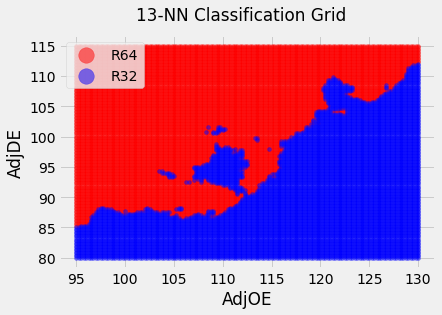

In [459]:
# a visualization of the k-NN classification grid

# k-NN algorithm
plots.scatter(test_grid.AdjOE[grid == 1], test_grid.AdjDE[grid == 1], 
              color = 'red', alpha = 0.5, s = 15,
              label = 'R64')
plots.scatter(test_grid.AdjOE[grid == 2], test_grid.AdjDE[grid == 2], 
              color = 'blue', alpha = 0.5, s = 15,
             label = 'R32')

plots.suptitle('13-NN Classification Grid')
plots.legend(loc = "upper left", markerscale = 4)
plots.xlabel('AdjOE')
plots.ylabel('AdjDE');

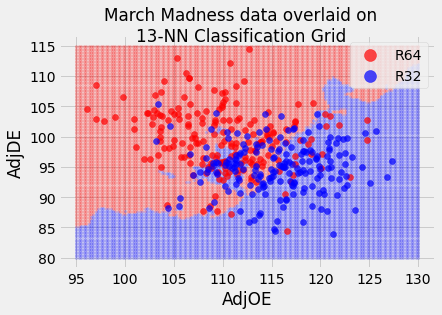

In [456]:
# a visualization of the k-NN classification grid (shaded in background), 
# with the entire dataset overlaid on top

# k-NN grid
plots.scatter(test_grid.AdjOE[grid == 1], test_grid.AdjDE[grid == 1], 
              color = 'red', alpha = 0.2, s = 5)
plots.scatter(test_grid.AdjOE[grid == 2], test_grid.AdjDE[grid == 2], 
              color = 'blue', alpha = 0.2, s = 5)

# teams data
plots.scatter(teams[teams.finish == 1]['AdjOE'], teams[teams.finish == 1]['AdjDE'],
              color = "red", label = "R64", alpha = 0.7)
plots.scatter(teams[teams.finish == 2]['AdjOE'], teams[teams.finish == 2]['AdjDE'],
              color = "blue", label = "R32", alpha = 0.7)

plots.suptitle('March Madness data overlaid on\n13-NN Classification Grid')
plots.legend(loc = "upper right", markerscale = 2)
plots.xlabel('AdjOE')
plots.ylabel('AdjDE');